In [21]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from netcal.metrics import ECE
import robustness_metrics as rm
import sklearn
import tensorflow as tf

import random

from utils_notebook import get_logits_targets, modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized, get_scale_probs
from utils_conformal import conformalize_anytime_nn
from utils_uncertainty import oracle_collab_acc_np, oracle_collab_auc_np, temper_probs, get_ood_scores, get_ood_detection_roc

import seaborn as sns
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib 

text_width = 5.50107 # in  --> Confirmed with template explanation
dpi = 300

fs_m1 = 10  # for figure ticks
fs = 12  # for regular figure text
fs_p1 = 14 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [3]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}

In [5]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [6]:
scaled_dict = get_scale_probs(['PoE-OVR (tempered)'], [probs_poe_ovr_break_ties_generalized], [2.], targets, C=ARGS.num_classes, L=L)
probs_poe_ovr_break_ties_generalized_tempered = scaled_dict['PoE-OVR (tempered)'][2.0][0]

In [10]:
_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(probs_poe_ovr_break_ties_generalized, .5)
_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(
    probs_poe_ovr_break_ties_generalized,
    np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None]).to(torch.float32)

In [12]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [13]:
random.seed(10)
CALIB_SIZE = 0.2
ALPHA = 0.05
calib_ids = random.sample(range(N), int(CALIB_SIZE * N))
valid_ids = list(set(range(N)) - set(calib_ids))

sizes_conf_sets,_ = conformalize_anytime_nn(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets_poe,_ = conformalize_anytime_nn(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn(_probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi, _ = conformalize_anytime_nn(_probs_poe_ovr_break_ties_generalized_tempered_multi.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')

1 0.998137
2 0.9985914
3 0.9993837
4 0.9993656
5 0.9995949
6 0.9997914
7 0.99969244
1 0.998137
2 0.9961053
3 0.9956329
4 0.99712837
5 0.99638087
6 0.9961833
7 0.99708503
1 0.9777752
2 0.9666052
3 0.9553259
4 0.9454552
5 0.9401411
6 0.9426813
7 0.95648557
1 0.97532016
2 0.9595121
3 0.944371
4 0.9440615
5 0.9521468
6 0.971708
7 0.9905887
1 0.9700028
2 0.9518818
3 0.94375217
4 0.95198345
5 0.9641138
6 0.9778432
7 0.9905887


In [14]:
entropy_baseline = scipy.stats.entropy(probs.numpy(), axis=2)
entropy_poe = scipy.stats.entropy(probs_poe.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized = scipy.stats.entropy(probs_poe_ovr_break_ties_generalized.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered_multi = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered_multi.numpy(), axis=2)

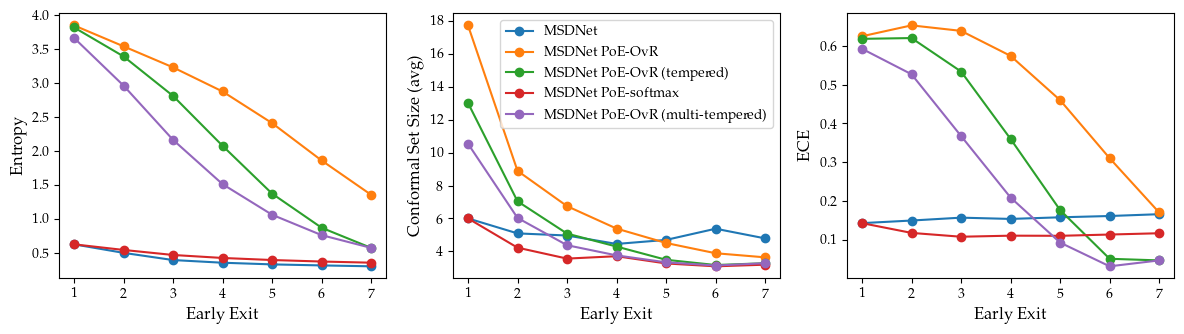

In [16]:
NAMES = ['MSDNet', 'MSDNet PoE-OvR', 'MSDNet PoE-OvR (tempered)', 'MSDNet PoE-softmax', 'MSDNet PoE-OvR (multi-tempered)']
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
PROBS = [
    probs,
    probs_poe_ovr_break_ties_generalized,
    _probs_poe_ovr_break_ties_generalized_tempered,
    probs_poe,
    _probs_poe_ovr_break_ties_generalized_tempered_multi
]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5 * 1))

for _entropy, label, color in zip([entropy_baseline, entropy_poe_ovr_break_ties_generalized, entropy_poe_ovr_break_ties_generalized_tempered, entropy_poe, entropy_poe_ovr_break_ties_generalized_tempered_multi], NAMES, COLORS):
    ax[0].plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label, color=color, alpha=1)
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Entropy')


for _sizes, label, color in zip([sizes_conf_sets, sizes_conf_sets_poe_ovr_break_ties_generalized, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, sizes_conf_sets_poe, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi], NAMES, COLORS):
    ax[1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label, color=color)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Conformal Set Size (avg)')
ax[1].legend()


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    eces = []
    eces_rm = []
    for l in range(L):
        # eces.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    # ax[2].plot(list(range(1, L + 1)), eces, '-', marker='o', label=label, color=color, alpha=0.5)
    ax[2].plot(list(range(1, L + 1)), eces_rm, '-', marker='o', label=label, color=color, alpha=1)
ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel('ECE')


plt.tight_layout()
plt.savefig(f'figures/figure_4.pdf', dpi=1200, bbox_inches='tight')
plt.show()

MSDNet {0.01: 66.95, 0.05: 55.589999999999996, 0.1: 48.94, 0.2: 40.39, 0.5: 19.79}
MSDNet PoE-OvR {0.01: 0.5599999999999999, 0.05: 0.0, 0.1: 0.0, 0.2: 0.0, 0.5: 0.0}
MSDNet PoE-OvR (tempered) {0.01: 4.43, 0.05: 0.5599999999999999, 0.1: 0.1, 0.2: 0.0, 0.5: 0.0}
MSDNet PoE-softmax {0.01: 38.25, 0.05: 23.78, 0.1: 15.260000000000002, 0.2: 6.92, 0.5: 0.5599999999999999}
MSDNet PoE-OvR (multi-tempered) {0.01: 9.610000000000001, 0.05: 2.03, 0.1: 0.38999999999999996, 0.2: 0.02, 0.5: 0.0}


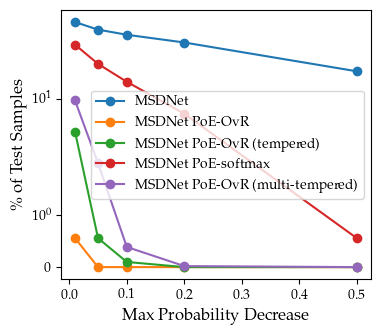

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

for _probs, label, color in zip(PROBS, NAMES, COLORS):
    preds = probs.argmax(dim=-1)
    modal_probs = modal_probs_decreasing(preds, _probs, L, N=N)
    print(label, modal_probs)

    ax.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label, color=color, alpha=1)

ax.set_xlabel('Max Probability Decrease')
ax.set_ylabel('\% of Test Samples')
ax.legend()
# set log scale
ax.set_yscale('symlog')

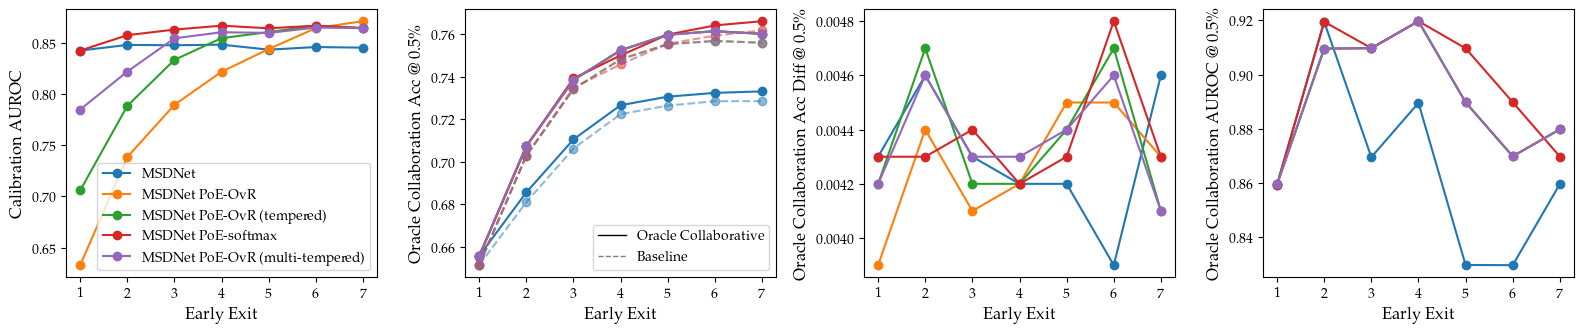

In [18]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

# NAMES = ['MSDNet', 'MSDNet PoE-OvR', 'MSDNet PoE-OvR (tempered)', 'MSDNet PoE-softmax']

fig, ax = plt.subplots(1, 4, figsize=(16, 3.5 * 1))

for _probs, label, color in zip(PROBS, NAMES, COLORS):
    calib_aucs = []
    for l in range(L):
        calib_auc = rm.metrics.CalibrationAUC(correct_pred_as_pos_label=False, curve='ROC')
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)
        calib_auc.add_batch(_preds, label=targets.numpy(), confidence=_probs[l, :, :].numpy().max(axis=-1))
        calib_aucs.append(calib_auc.result()['calibration_auc'])
    ax[0].plot(list(range(1, L + 1)), calib_aucs, marker='o', label=label, color=color)
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Calibration AUROC')
ax[0].legend()




FRACTION = 0.005


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_accs = []
    accs = []
    for l in range(L):
        oracle_accs.append(oracle_collab_acc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy().max(axis=-1), 
            FRACTION, 
            diff=False))
        accs.append(oracle_collab_acc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy().max(axis=-1),
            0.,
            diff=False))

    ax[1].plot(list(range(1, L + 1)), oracle_accs, marker='o', label=label, color=color, alpha=1)
    ax[1].plot(list(range(1, L + 1)), accs, '--', marker='o', label=label, color=color, alpha=0.5)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel(f'Oracle Collaboration Acc @ {FRACTION * 100}\%')
# create legend to compare the two lines: solid (oracle colaborative) and dashed (baseline)
ax[1].legend([
    matplotlib.lines.Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=1),
    matplotlib.lines.Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.5)],
    ['Oracle Collaborative', 'Baseline']
    )


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_accs = []
    for l in range(L):
        oracle_accs.append(oracle_collab_acc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy().max(axis=-1), 
            FRACTION, 
            diff=True))

    ax[2].plot(list(range(1, L + 1)), oracle_accs, marker='o', label=label, color=color, alpha=1)
ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel(f'Oracle Collaboration Acc Diff @ {FRACTION * 100}\%')



FRACTION = 0.005

for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_aucs = []
    oracle0_aucs = []
    oracle100_aucs = []
    keras_oracle_aucs = []
    for l in range(L):
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

    ax[3].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o',  label=label, alpha=1., color=color)
ax[3].set_xlabel('Early Exit')
ax[3].set_ylabel(f'Oracle Collaboration AUROC @ {FRACTION * 100}\%')



plt.tight_layout()
plt.savefig(f'figures/figure_4b.pdf', dpi=1200)
plt.show()

In [19]:
svhn_ood_logits, _, _ = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, ood_dataset='svhn')
cifar10_ood_logits, _, _ = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, ood_dataset='cifar10')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [22]:
# baseline scores
svhn_ood_probs = torch.softmax(svhn_ood_logits, dim=2)
cifar10_ood_probs = torch.softmax(cifar10_ood_logits, dim=2)

(_, msp_baseline) = get_ood_scores(probs) # entropy baseline is already calculated
(cifar10_ood_entropy_baseline, cifar10_ood_msp_baseline) = get_ood_scores(cifar10_ood_probs)
(svhn_ood_entropy_baseline, svhn_ood_msp_baseline) = get_ood_scores(svhn_ood_probs)


# PoE scores
svhn_ood_probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(svhn_ood_logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
cifar10_ood_probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(cifar10_ood_logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))

(_, msp_poe_ovr_break_ties_generalized) = get_ood_scores(probs_poe_ovr_break_ties_generalized)
(cifar10_ood_entropy_poe_ovr_break_ties_generalized, cifar10_ood_msp_poe_ovr_break_ties_generalized) = get_ood_scores(cifar10_ood_probs_poe_ovr_break_ties_generalized)
(svhn_ood_entropy_poe_ovr_break_ties_generalized, svhn_ood_msp_poe_ovr_break_ties_generalized) = get_ood_scores(svhn_ood_probs_poe_ovr_break_ties_generalized)

# PoE tempered scores
svhn_ood_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(svhn_ood_probs_poe_ovr_break_ties_generalized, .5)
cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(cifar10_ood_probs_poe_ovr_break_ties_generalized, .5)

(_, msp_poe_ovr_break_ties_generalized_tempered) = get_ood_scores(_probs_poe_ovr_break_ties_generalized_tempered)
(cifar10_ood_entropy_poe_ovr_break_ties_generalized_tempered, cifar10_ood_msp_poe_ovr_break_ties_generalized_tempered) = get_ood_scores(cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered)
(svhn_ood_entropy_poe_ovr_break_ties_generalized_tempered, svhn_ood_msp_poe_ovr_break_ties_generalized_tempered) = get_ood_scores(svhn_ood_probs_poe_ovr_break_ties_generalized_tempered)

# PoE tempered multi scores
svhn_ood_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(svhn_ood_probs_poe_ovr_break_ties_generalized, np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None])
cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(cifar10_ood_probs_poe_ovr_break_ties_generalized, np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None])

(_, msp_poe_ovr_break_ties_generalized_tempered_multi) = get_ood_scores(_probs_poe_ovr_break_ties_generalized_tempered_multi)
(cifar10_ood_entropy_poe_ovr_break_ties_generalized_tempered_multi, cifar10_ood_msp_poe_ovr_break_ties_generalized_tempered_multi) = get_ood_scores(cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered_multi)
(svhn_ood_entropy_poe_ovr_break_ties_generalized_tempered_multi, svhn_ood_msp_poe_ovr_break_ties_generalized_tempered_multi) = get_ood_scores(svhn_ood_probs_poe_ovr_break_ties_generalized_tempered_multi)

# PoE softmax scores
svhn_ood_logits_poe = svhn_ood_logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
svhn_ood_probs_poe = torch.softmax(svhn_ood_logits_poe, dim=2)

cifar10_ood_logits_poe = cifar10_ood_logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
cifar10_ood_probs_poe = torch.softmax(cifar10_ood_logits_poe, dim=2)

(_, msp_poe) = get_ood_scores(probs_poe)
(cifar10_ood_entropy_poe, cifar10_ood_msp_poe) = get_ood_scores(cifar10_ood_probs_poe)
(svhn_ood_entropy_poe, svhn_ood_msp_poe) = get_ood_scores(svhn_ood_probs_poe)

/var/home/jua23/miniconda3/envs/msdn/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/var/home/jua23/miniconda3/envs/msdn/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/var/home/jua23/miniconda3/envs/msdn/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/var/home/jua23/miniconda3/envs/msdn/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/var/home/jua23/miniconda3/envs/msdn/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples i

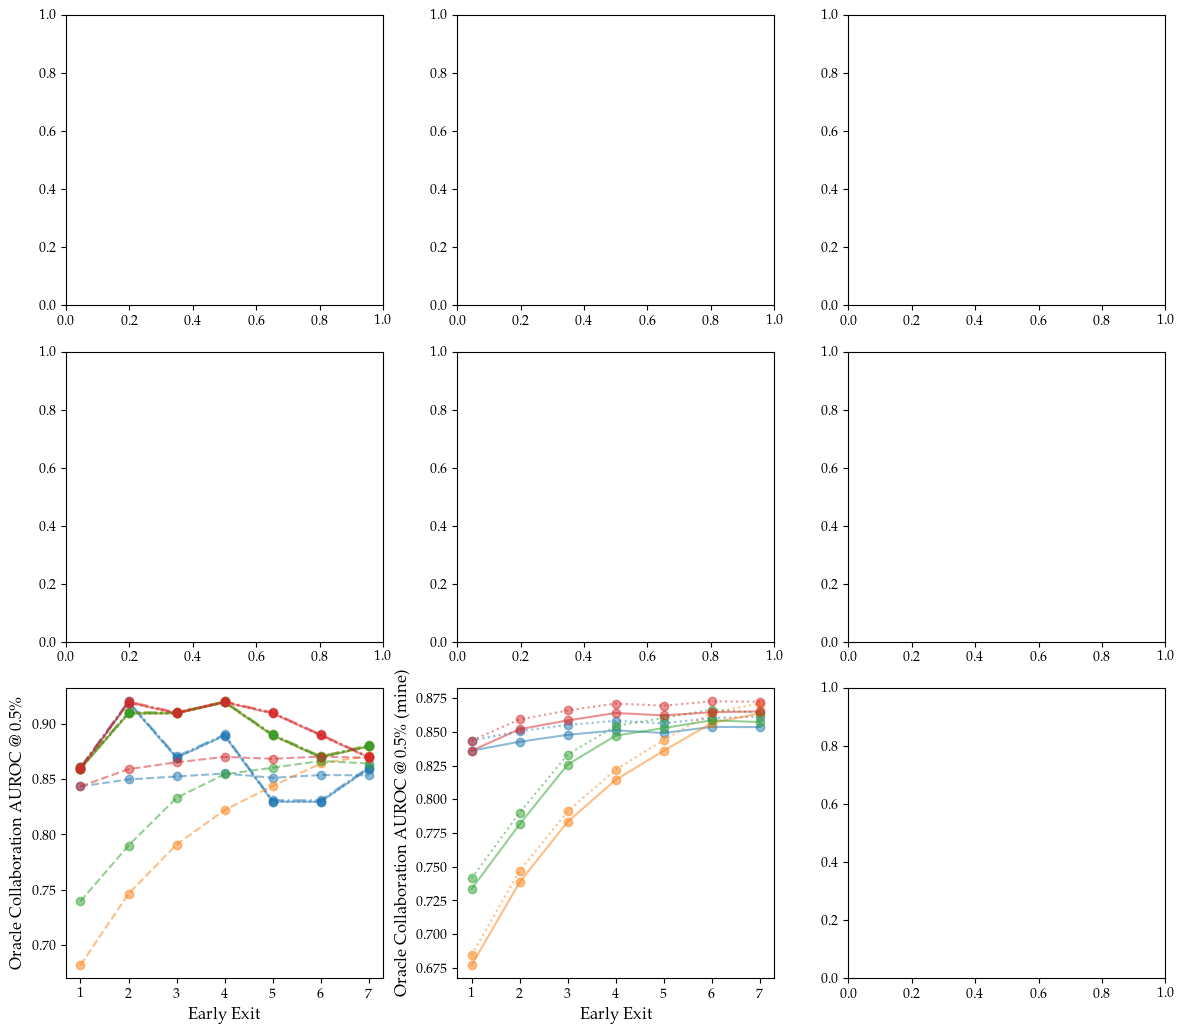

In [23]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

NAMES = ['MSDNet', 'MSDNet PoE-OvR', 'MSDNet PoE-OvR (tempered)', 'MSDNet PoE-softmax']
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, ax = plt.subplots(3, 3, figsize=(12, 3.5 * 3))

# for _probs, label in zip([probs, probs_poe_ovr_break_ties_generalized, _probs_poe_ovr_break_ties_generalized_tempered, probs_poe], NAMES):
#     calib_aucs = []
#     for l in range(L):
#         calib_auc = rm.metrics.CalibrationAUC(correct_pred_as_pos_label=False, curve='ROC')
#         _preds = _probs[l, :, :].numpy().argmax(axis=-1)
#         calib_auc.add_batch(_preds, label=targets.numpy(), confidence=_probs[l, :, :].numpy().max(axis=-1))
#         calib_aucs.append(calib_auc.result()['calibration_auc'])
#         # calib_aucs.append(cal_auc_np(
#         #     _probs[l, :, :].numpy().argmax(axis=-1),
#         #     targets.numpy(),
#         #     _probs[l, :, :].numpy().max(axis=-1)))
#     ax[0, 0].plot(list(range(1, L + 1)), calib_aucs, marker='o', label=label)
# ax[0, 0].set_xlabel('Early Exit')
# ax[0, 0].set_ylabel('Calibration AUROC')


# for _probs, label in zip([probs, probs_poe_ovr_break_ties_generalized, _probs_poe_ovr_break_ties_generalized_tempered, probs_poe], NAMES):
#     calib_aucs = []
#     for l in range(L):
#         calib_aucs.append(cal_auc_np(
#             _probs[l, :, :].numpy().argmax(axis=-1),
#             targets.numpy(),
#             _probs[l, :, :].numpy().max(axis=-1)))
#     ax[0, 1].plot(list(range(1, L + 1)), calib_aucs, marker='o', label=label)
# ax[0, 1].set_xlabel('Early Exit')
# ax[0, 1].set_ylabel('Calibration AUROC (mine)')


# FRACTION = 0.2


# ## This doesn't seem to work... not sure why :( it isn't the same result as the below, which seems to pass sanity checks
# ## E.g., as the oracle fraction increases, the overall accuracy should increase
# ## Also, the overall accuracy should be the same as the accuracy of the classifier when the fraction is 0
# ## Also the overall accuracy should be perfect when the fraction is 1
# for _probs, label, color in zip(
#     [probs, probs_poe_ovr_break_ties_generalized, _probs_poe_ovr_break_ties_generalized_tempered, probs_poe],
#     NAMES,
#     COLORS):
#     oracle0_accs = []
#     oracle100_accs = []
#     oracle_accs = []
#     for l in range(L):
#         _preds = _probs[l, :, :].numpy().argmax(axis=-1)

#         oracle_acc = rm.metrics.OracleCollaborativeAccuracy(fraction=FRACTION,
#                                                             num_bins=1000)
#         oracle_acc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
#         oracle_accs.append(oracle_acc.result()['collaborative_accuracy'])

#         oracle_acc = rm.metrics.OracleCollaborativeAccuracy(fraction=0.,
#                                                             num_bins=1000)
#         oracle_acc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
#         oracle0_accs.append(oracle_acc.result()['collaborative_accuracy'])

#         oracle_acc = rm.metrics.OracleCollaborativeAccuracy(fraction=1.,
#                                                             num_bins=1000)
#         oracle_acc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
#         oracle100_accs.append(oracle_acc.result()['collaborative_accuracy'])
#     ax[1, 0].plot(list(range(1, L + 1)), oracle_accs, marker='o', label=label, color=color, alpha=0.5)
#     ax[1, 0].plot(list(range(1, L + 1)), oracle0_accs, ':', marker='o', label=label, color=color, alpha=0.5)
#     ax[1, 0].plot(list(range(1, L + 1)), oracle100_accs, '-.', marker='o', label=label, color=color, alpha=0.5)
# ax[1, 0].set_xlabel('Early Exit')
# ax[1, 0].set_ylabel(f'Oracle Collaboration Acc @ {FRACTION * 100}\%')


# for _probs, label, color in zip(
#     [probs, probs_poe_ovr_break_ties_generalized, _probs_poe_ovr_break_ties_generalized_tempered, probs_poe],
#     NAMES,
#     COLORS):
#     accs = []
#     oracle0_accs = []
#     oracle100_accs = []
#     oracle_accs = []
#     for l in range(L):
#         accs.append(((_probs[l, :, :].numpy().argmax(axis=-1) == targets.numpy()).mean()))
        
#         oracle_accs.append(oracle_collab_acc_np(
#             _probs[l, :, :].numpy().argmax(axis=-1),
#             targets.numpy(),
#             _probs[l, :, :].numpy().max(axis=-1), 
#             FRACTION, 
#             diff=False))

#         oracle0_accs.append(oracle_collab_acc_np(
#             _probs[l, :, :].numpy().argmax(axis=-1),
#             targets.numpy(),
#             _probs[l, :, :].numpy().max(axis=-1), 
#             0, 
#             diff=False))
        
#         oracle100_accs.append(oracle_collab_acc_np(
#             _probs[l, :, :].numpy().argmax(axis=-1),
#             targets.numpy(),
#             _probs[l, :, :].numpy().max(axis=-1), 
#             1, 
#             diff=False))
#     ax[1, 1].plot(list(range(1, L + 1)), oracle_accs, marker='o', label=label, color=color, alpha=0.5)
#     ax[1, 1].plot(list(range(1, L + 1)), accs, '--', marker='o', label=label, color=color, alpha=0.5)
#     ax[1, 1].plot(list(range(1, L + 1)), oracle0_accs, ':', marker='o', label=label, color=color, alpha=0.5)
#     ax[1, 1].plot(list(range(1, L + 1)), oracle100_accs, '-.', marker='o', label=label, color=color, alpha=0.5)
# ax[1, 1].set_xlabel('Early Exit')
# ax[1, 1].set_ylabel(f'Oracle Collaboration Acc @ {FRACTION * 100}\% (mine)')


# for _probs, label in zip([probs, probs_poe_ovr_break_ties_generalized, _probs_poe_ovr_break_ties_generalized_tempered, probs_poe], NAMES):
#     oracle_accs = []
#     for l in range(L):
#         oracle_accs.append(oracle_collab_acc_np(
#             _probs[l, :, :].numpy().argmax(axis=-1),
#             targets.numpy(),
#             _probs[l, :, :].numpy().max(axis=-1), 
#             FRACTION))
#     ax[1, 2].plot(list(range(1, L + 1)), oracle_accs, marker='o', label=label, alpha=1)
# ax[1, 2].set_xlabel('Early Exit')
# ax[1, 2].set_ylabel(f'Oracle Collaboration Acc Diff @ {FRACTION * 100}\% (mine)')





FRACTION = 0.005

for _probs, label, color in zip([probs, probs_poe_ovr_break_ties_generalized, _probs_poe_ovr_break_ties_generalized_tempered, probs_poe], NAMES, COLORS):
    oracle_aucs = []
    oracle0_aucs = []
    oracle100_aucs = []
    keras_oracle_aucs = []
    for l in range(L):
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=0.,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle0_aucs.append(oracle_auc.result()['collaborative_auc'])

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=1.,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle100_aucs.append(oracle_auc.result()['collaborative_auc'])

        oracle_auc = tf.keras.metrics.AUC(num_thresholds=1000)
        oracle_auc.update_state(targets.numpy() == _preds, _probs[l, :, :].numpy().max(axis=-1))
        keras_oracle_aucs.append(oracle_auc.result().numpy())

    ax[2, 0].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o',  label=label, alpha=0.5, color=color)
    ax[2, 0].plot(list(range(1, L + 1)), oracle0_aucs, ':', marker='o',  label=label, alpha=0.5, color=color)
    ax[2, 0].plot(list(range(1, L + 1)), oracle100_aucs, '-.', marker='o', label=label, alpha=0.5, color=color)
    ax[2, 0].plot(list(range(1, L + 1)), keras_oracle_aucs, '--', marker='o', label=label, alpha=0.5, color=color)
ax[2, 0].set_xlabel('Early Exit')
ax[2, 0].set_ylabel(f'Oracle Collaboration AUROC @ {FRACTION * 100}\%')





for _probs, label, color in zip([probs, probs_poe_ovr_break_ties_generalized, _probs_poe_ovr_break_ties_generalized_tempered, probs_poe], NAMES, COLORS):
    oracle_aucs = []
    oracle0_aucs = []
    oracle100_aucs = []
    for l in range(L):
        oracle_aucs.append(oracle_collab_auc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy(), 
            FRACTION))

        oracle0_aucs.append(oracle_collab_auc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy(), 
            0.))

        oracle100_aucs.append(oracle_collab_auc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy(), 
            1.))
    ax[2, 1].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o', label=label, alpha=0.5, color=color)
    ax[2, 1].plot(list(range(1, L + 1)), oracle0_aucs, ':', marker='o', label=label, alpha=0.5, color=color)
    ax[2, 1].plot(list(range(1, L + 1)), oracle100_aucs, '-.', marker='o', label=label, alpha=0.5, color=color)
ax[2, 1].set_xlabel('Early Exit')
ax[2, 1].set_ylabel(f'Oracle Collaboration AUROC @ {FRACTION * 100}\% (mine)')



plt.tight_layout()
plt.savefig(f'figures/figure_4b.pdf', dpi=1200)
plt.show()